In [1]:
import tensorflow as tf
import numpy as np

import random, math, itertools
from collections import defaultdict, deque, Counter

import matplotlib.pylab as plt

%load_ext autoreload
%autoreload 2

In [17]:
m = 512 # code weight matrix dimension
n = 1024 # visit weight matrix dimension
code_len = 5

max_iter = 2000
max_iter_progress_report = 100

batch_size = 10

In [18]:
import data.coril as coril
import data.vectorize as vectorize

In [19]:
observations, dictionary, reverse_dictionary = coril.read_visits("mic.seq", code_len=code_len)
C = len(dictionary)
print(C)

259


In [20]:
med2vec = tf.Graph()

with med2vec.as_default():
    
    # x represents a number of visits visits
    x = tf.placeholder(tf.float32, shape=(None, C))
    
    # y represents the context of a visit e.g., a label in another visit
    y = tf.placeholder(tf.float32, shape=(None, C))
    
    # the bias term for the code representation
    b_c = tf.Variable(tf.zeros([m]), name="b_c")
    
    # the code vector
    # each code 1..C, is represented by a vector of m elements
    # initialized with a small random number
    W_c = tf.Variable(tf.random_uniform([C, m], -0.01, 0.01), name="W_c")
    
    # the intermidiate visit representation is given by the
    # sum of the visits (each row of x) multiplied by the code vector 
    # which is a column of W_c
    #u_t = tf.nn.relu(tf.matmul(x, W_c) + b_c, name="u_t")
    u_t = tf.nn.relu_layer(x, W_c, b_c)
    
    # the bias term for the visit representation
    b_v = tf.Variable(tf.zeros([n]))
    
    # the visit weight matrix.  
    W_v = tf.Variable(tf.random_uniform([m, n], -0.01, 0.01))
        
    #v_t = tf.nn.relu(tf.matmul(u_t, W_v) + b_v, name="v_t")
    v_t = tf.nn.relu_layer(u_t, W_v, b_v)
    
    b_s = tf.Variable(tf.zeros([C]))
    W_s = tf.Variable(tf.random_uniform([n, C], -0.01, 0.01))
    
    y_t = tf.matmul(v_t, W_s) + b_s
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_t, labels=y))
    reg_loss = loss + (0.001 * (tf.nn.l2_loss(W_v) + tf.nn.l2_loss(W_c) + tf.nn.l2_loss(W_s)))
   
    global_step = tf.Variable(0)
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.96, staircase=True)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(reg_loss, global_step=global_step)
    init = tf.global_variables_initializer()
    
    
with tf.Session(graph=med2vec) as session:

    init.run()
    loss_values = []
    tmp_loss = []
    
    #vec_obs = vectorize.simple_input_output_generator(
    #    observations, dictionary, max_skip_ahead=5, random_output=False)
    vec_obs = vectorize.random_input_output_generator(
        observations, dictionary, window_size=1, sample=3)
    vec_cycle = itertools.cycle(vec_obs)
    for i in range(max_iter):
        x_data, y_data = vectorize.generate_batch(vec_cycle, batch_size=batch_size)
        _, loss_value,  = session.run([optimizer, loss], feed_dict= {x: x_data, y: y_data})

        tmp_loss.append(loss_value)
        if i % max_iter_progress_report == 0:
            print(max_iter_progress_report, " iterations", np.mean(tmp_loss))
            loss_values.append(np.mean(tmp_loss))
            tmp_loss = []
        
    W_c_val = W_c.eval()
    W_v_val = W_v.eval()
    b_c_val = b_c.eval()

100  iterations 5.55685
100  iterations 5.01945
100  iterations 4.44075
100  iterations 4.23166
100  iterations 3.85642
100  iterations 3.37367
100  iterations 2.86229
100  iterations 2.59532
100  iterations 2.23686
100  iterations 2.0227
100  iterations 1.89492
100  iterations 1.85474
100  iterations 1.82032
100  iterations 1.78312
100  iterations 1.75218
100  iterations 1.75993
100  iterations 1.75837
100  iterations 1.72195
100  iterations 1.71153
100  iterations 1.72273


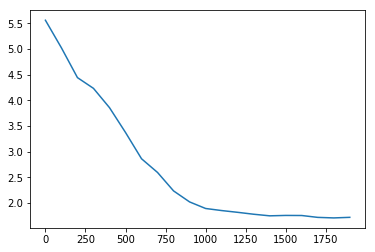

In [21]:
plt.plot(range(0, max_iter, max_iter_progress_report), loss_values)
plt.show()

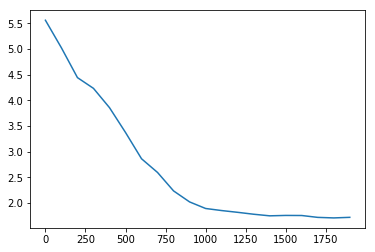

In [22]:
plt.plot(range(0, max_iter, max_iter_progress_report), loss_values)
plt.show()

In [23]:
def read_translate(f, code_len=None):
    with open(f) as lines:
        d = {}
        for code, translation in map(lambda x: x.strip().split("|"), lines):
            d[code[:code_len] if code_len is not None else code] = translation
        return d
icd_translator = read_translate("icd10.txt", code_len=code_len)

In [24]:
import data.mimic as mimic

mimic_trans = mimic.read_translator("D_ICD_DIAGNOSES.csv")

In [25]:
def make_translator(*translators):
    def f(code):
        r = code
        for translator in translators:
            r = translator[code]
            if r is None:
                return code
            code = r
        return code
    return f

translator = make_translator(reverse_dictionary, mimic_trans)
translator(0)

'Cirrhosis of liver NOS'

In [27]:
list(map(lambda f: translator(f), np.argsort(np.maximum(W_c_val, 0)[:,100])[::-1][:10]))

['Acidosis',
 'Thrombocytopenia NOS',
 'Glossitis',
 'Mult mye w/o achv rmson',
 'Bacteremia',
 'Long-term use of insulin',
 'Periph vascular dis NOS',
 'Cor ath unsp vsl ntv/gft',
 'Gastroduodenal dis NEC',
 'Alcoh dep NEC/NOS-remiss']

In [30]:
W_c_val[:,1].shape

(259,)